In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## 2.2 Non-linear regression using basis functions

In the [previous section](regression_linear.ipynb) we showed how linear regression can be used to make predictions in datasets where the underlying input-output relation is linear. In this section we show how to extend linear regression to handle underyling functions that are non-linear. A running example dataset will be:

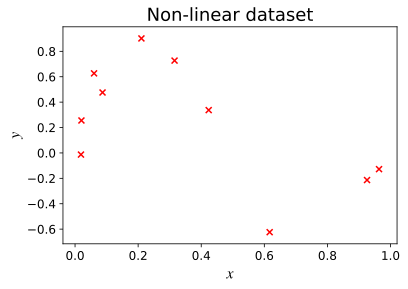

In [3]:
x_nonlin = np.load('reg_nonlin_x.npy') # load inputs from a prepared non-linear dataset
y_nonlin = np.load('reg_nonlin_y.npy') # load corresponding outputs

plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red')
beautify_plot({"title":"Non-linear dataset", "x":"$x$", "y":"$y$"})
plt.show()

toggle_code()

In this section we will make use of the insight that we can retain much of the machinery developed earlier by modelling the underlying non-linear function as a linear combination of non-linear basis functions \\(\phi_d(x), d = 0, 1, ..., D\\). 

\\[y_n = f(x_n) + \epsilon_n ~\text{where}~ \epsilon_n \sim \mathcal{N}(0, \sigma_{y}^2) ~\text{and}\\
f(x_n) = w_0 + w_1 \phi_{1}(x_n) + w_2 \phi_{2}(x_n) + ... w_D \phi_{D}(x_n).
\\]

Suitable choices for the non-linear basis functions might include polynomials $\phi_{d}(x) = x^d$, sinusoids $\phi_{d}(x) = \cos(\omega_d x + \phi_d)$, or Gaussian bumps $\phi_d(x) = \exp(-(x - \mu_d)^2/(2\sigma^2) )$. Here's an example of a non-linear function constructed from a linear combination of 10 Gaussian bumps.

<div class="row">
  <div class="column">
    <img src="non-linear-schematic.svg" alt="Snow" style="width:80%; float: center; padding: 0px; padding : 20px">
  </div>
</div>

### Least squares and maximum likelihood fitting

The beauty of this approach to non-linear regression is that **the model is still linear in the parameters** and so fitting proceeds in an analogous manner to the linear case. First, we rewrite the model in terms of a $D+1$ dimensional vector of parameters $\mathbf{w} = [w_0,...,w_{D}]^\top$ so that

\\[y_n = w_0 + w_1 \phi_{1}(x_n) + w_2 \phi_{2}(x_n) + ... w_D \phi_{D}(x_n) + \epsilon_n = \boldsymbol{\phi}(x_n)^\top \mathbf{w} + \epsilon_n.\\]

Second, we can collect all of the observations and observation noise variables into  $N$ dimensional vectors $\mathbf{y} = [y_1,...,y_{N}]^\top$ and $\boldsymbol{\epsilon} = [\epsilon_1,...,\epsilon_{N}]^\top$ giving

\\[\mathbf{y} = \boldsymbol{\Phi}\mathbf{w} + \boldsymbol{\epsilon}\\].

Here \\(\boldsymbol{\Phi}\\) is called the **design matrix** whose entry at the \\(d^{th}\\) row and \\(n^{th}\\) column is \\(\phi_d(x_n)\\),

\begin{equation}
\boldsymbol{\Phi} =  \begin{pmatrix}
1 & \phi_1(x_1) & \cdots & \phi_D(x_1)\\\
1 & \phi_1(x_2) & \cdots & \phi_D(x_2)\\\
\vdots & \vdots & \ddots & \vdots \\\
1 & \phi_1(x_N) & \cdots & \phi_D(x_N)
\end{pmatrix}.
\end{equation}

Notice that we have assumed that the \\(0^{th}\\) basis function is $1$ to recover the constant \\(w_0\\) term when multiplied by \\(\mathbf{w}\\). You should convince yourself that this matrix gives the correct linear combination when acting on \\(\mathbf{w}\\). 

We can now proceed either by applying the least squares approach with error:

\\[C_2 = \big|\big| \mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big|\big|^2 = \big(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big)^\top \big(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w}\big),\\]

or by minimising the negative log-likelihood:

\\[- \mathcal{L}(\mathbf{w}) = - \text{log}~ p(\mathbf{y}|\boldsymbol{\Phi}, \mathbf{w}, \sigma_y^2) = \frac{N}{2}\text{log}(2\pi \sigma^2) + \frac{1}{2\sigma^2}(\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})^\top (\mathbf{y} - \boldsymbol{\Phi}\mathbf{w})\\]

with respect to $\mathbf{w}$. Again it is easy to convince yourself that the two approaches are equivalent, and that the maximum-likelihood weights are:

\begin{align}
\boxed{\mathbf{w} = \big( \boldsymbol{\Phi}^\top\boldsymbol{\Phi}\big)^{-1}\boldsymbol{\Phi}^\top \mathbf{y}}.
\end{align}

So, the only change we need to make to our old implementation is to compute the design matrix $\boldsymbol{\Phi}$. 

Let's fit the model to the toy dataset above using some different choices of basis function. First, we use polynomial basis functions \\(\phi_d(x) = x^d\\) selecting the order $D = 5$.

Sum squared errors for polynomial of order 5: 0.091


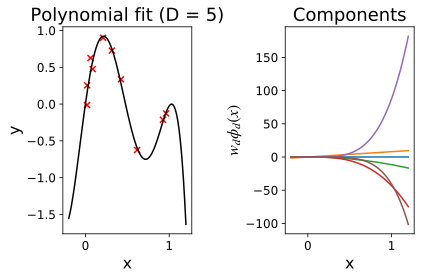

In [5]:
D = 5

phi = np.array([[x_ ** d for d in range(D + 1)] for x_ in x_nonlin]) # build the design matrix Phi

# compute the optimal w using the Moore-Penrose pseudoinverse
w = np.linalg.solve( (phi.T).dot(phi) , (phi.T).dot(y_nonlin) )

# As with linear regression, the line above is numerically stable version of line commented line below (e.g. it works with D>N)
# w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_nonlin) # apply the Moore-Penrose pseudoinverse using Phi

xs = np.linspace(-0.2, 1.2, 100) # 100 points equispaced between 0 and 1

phi_pred = np.array([[x_ ** d for d in range(D + 1)] for x_ in xs]) # design matrix for points at which to plot

ys = phi_pred.dot(w) # output of the model at the points above


######## Plotting code #######
print('Sum squared errors for polynomial of order {}:'.format(D), np.sum((phi.dot(w) - y_nonlin) ** 2).round(3))
plt.subplot(1,2,1)
plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red') # plot model predictions
plt.plot(xs, ys, color = 'black') # plot dataset
beautify_plot({"title":"Polynomial fit (D = {})".format(D), "x":"x", "y":"y"})


plt.subplot(1,2,2)

for d in range(D+1):
 plt.plot(xs, w[d]*phi_pred[:,d]) # plot coefficients

beautify_plot({"title":"Components".format(D), "x":"x", "y":"$w_d  \phi_d(x)$"})


plt.tight_layout()
plt.show()

toggle_code()

Next we use $D=5$ Gaussian basis functions, \\(\phi_d(x) = \exp(-(x - \mu_d)^2/(2 \sigma^2_{\phi}))\\), with centres $\mu_d$ uniformly spaced between 0 and 1, and with widths $\sigma^2_{\phi} = 0.05$.

Sum squared errors for D =  5 Gaussian basis functions: 0.106


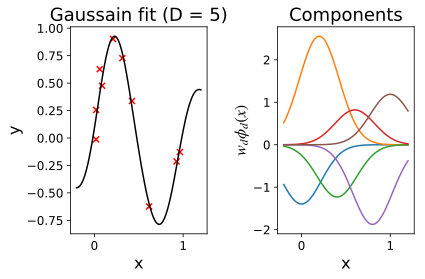

In [7]:
D = 5
var_phi = 0.05

phi = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in x_nonlin])

# compute the optimal w using the Moore-Penrose pseudoinverse
w = np.linalg.solve( (phi.T).dot(phi) , (phi.T).dot(y_nonlin) )

# As with linear regression, the line above is numerically stable version of line commented line below (e.g. it works with D>N)
# w = np.linalg.inv((phi.T).dot(phi)).dot(phi.T).dot(y_nonlin) # apply the Moore-Penrose pseudoinverse using Phi

xs = np.linspace(-0.2, 1.2, 100) # 100 points equispaced between 0 and 1

phi_pred = np.array( [[ np.exp(-1/(2*var_phi)*np.power(x_-d/D,2))  for d in range(D + 1) ]  for x_ in xs]) # design matrix for points at which to plot

ys = phi_pred.dot(w) # output of the model at the points above


print('Sum squared errors for D =  {} Gaussian basis functions:'.format(D), np.sum((phi.dot(w) - y_nonlin) ** 2).round(3))

plt.subplot(1,2,1)

plt.scatter(x_nonlin, y_nonlin, marker = 'x', color = 'red') # plot model predictions
plt.plot(xs, ys, color = 'black') # plot dataset
beautify_plot({"title":"Gaussain fit (D = {})".format(D), "x":"x", "y":"y"})


plt.subplot(1,2,2)

for d in range(D+1):
 plt.plot(xs, w[d]*phi_pred[:,d]) # plot coefficients

beautify_plot({"title":"Components".format(D), "x":"x", "y":"$w_d  \phi_d(x)$"})


plt.tight_layout()
plt.show()

toggle_code()

The two models make very similar predictions at the training data with similar training costs $\mathcal{C}_2 \approx 0.1$. The models interpolate very similarly, but extrapolate rather differently (compare the predictions around $x_2 = 1.2$). 

How sensitive are these properties to the hyper parameters? In the code above, **experiment with the model hyper parameters** to see how the fits depend upon:
1. the order of the polynomial (what happens as $D$ gets large?)
2. the number of Gaussian basis functions (what happens as $D$ grows for this model?)
3. the width of the basis functions $\sigma^2_{\phi}$ (explore the effect of narrow and wide basis functions)

By exploring these settings you should be able to find regimes in which the fitted function is overly simple (under-fitting) and where it is overly complex (over-fitting). These concepts are explored in the next [notebook](regression_overfitting.ipynb).

## Summary

Linear regression can be converted into non-linear regression by replacing the inputs $\mathbf{x}$ with $D$ basis functions $\phi_d(\mathbf{x})$ (also called features). 

The choice of basis function will effect how the model interpolates and extrapolates. One general approach to extrapolation is to turn it into an interpolation problem in the space defined by the basis functions, by a clever choice of $\phi_d(\mathbf{x})$.

## Questions 

1. How do the polynomial and Gaussian basis function models generalise far outside of the region of the data?

<details>
<summary>Answer</summary>
<div>
The polynomial model extrapolations explode according to the highest order term in the polynomial, $f(x) \rightarrow w_D x^D$. The Gaussian basis function model decays away to the constant function $f(x) \rightarrow w_0$ with a length scale related to the width of the basis functions $\approx \sigma_{\phi}$. These are very different behaviours. The extreme extrapolation of polynomials is often inappropriate. Although the extrapolation of the Gaussian model is benign, it limits the extrapolation ability to simple smoothing. 
    
You might like to alter the code to fit sinusoidal basis functions and compare how this class of basis function extropolates.
</div>
</details>

2. Consider a data set whose inputs live in $\text{dim}(\mathbf{x}) = K$ dimensions. Each input dimension is real valued and lies in the range $-L/2 < x_k < L/2$. The inputs are uniformly sampled from the input domain and the outputs are measured. The output function is known to change significantly according to a length-scale $l$. Estimate how many Gaussian basis functions are required to fit these data.

<details>
<summary>Answer</summary>
<div>
$\mathcal{O}((L/l)^K)$ basis functions will be needed. This is a combinatorial number. Fixed basis function models suffer from this _curse of dimensionality_. 
</div>
</details>

3. In order to side step the curse of dimensionality (see question 2), a machine learner would like to use adaptive basis functions. What's a simple data dependent way of selecting the centres $\mu_d$ and widths $\sigma_d^2$ of the Gaussian basis functions? 

<details>
<summary>Answer</summary>
<div>
For $\mu_d$ one idea is to place the centres at a randomly selected subset of the data points or to use a clustering algorithm like k-means. For the width, often the median distance between the centres and each data point is used. These simple approaches can mitigate the curse of dimensionality to some extent. A different flavour of approach is to use an infinite number of basis functions as utilised by kernel machines such as Gaussian processes.
</div>
</details>

4. Modifiy the code above to fit the data with sinusoidal basis functions, $\phi_d(x) = \sin(\omega_d x + \psi_d)$. It is sensible to use pairs of sines and cosines ($\psi_d = 0$, $\psi_{d+1} = \pi/2$) with the same frequency. Is there are relationship to Fourier transforms?
